# Association Rule

- 상품간의 연관성을 알아내어 소비자들이 보통 함께 구매하는 제품을 추천하는 방법
- 예를들어 핸드폰을 살 때 소비자들이 핸드폰 악세사리를 함께 구매하는 경향이 있으면 핸드폰 구매 고객에게 악세사리를 함께 추천할 수 있음
- E-commerce, 편의점 등에서 많이 사용
- 가장 유명한 일화는 맥주와 기저귀 구매의 연관성이 높음 => 아이를 가진 부부끼리 쇼핑을 하면서 아내가 기저귀를 구매하는 동안 남편이 맥주를 구매하기 때문이라는 분석이 있음

목차<br>
1. 데이터 탐색
2. 주요 개념과 용어
3. Apriori 알고리즘

# 1. 데이터 탐색

In [1]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/recommender_system')

In [2]:
def File_Reader(PATH):
    with open(PATH, 'r',encoding='utf-8') as file:
        data = file.readlines()
    data=[x.strip().split(',') for x in data]
    return data

#transaction data per item
df=File_Reader('./data/groceries.csv')

#whole transactions
df2=[]
for x in df:
    df2+=x
    
#unique items
Items= set(df2)

데이터:<br>
사용자마다 구매한 물품에 대한 거래 기록

<b>거래별 요약</b>

In [3]:
Basket_len=[]
for x in df:
    Basket_len.append( len(x))

In [4]:
import matplotlib.pyplot as plt
plt.hist(Basket_len,bins=range(min(Basket_len), max(Basket_len) + 1, 1) )
plt.title('Number of Items per Basket')
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
pd.DataFrame.from_dict( {'Total Purchase':[sum(Basket_len)],'Total Records':[len(Basket_len)],'Unique Items':[len(Items)] ,'Mean':[ sum(Basket_len)/len(Basket_len) ] , 'less than 5':[sum([x for x in Basket_len if x<=5])/sum(Basket_len)], 'Max': [max(Basket_len)] })

,Total Purchase,Total Records,Unique Items,Mean,less than 5,Max
0,43367,9835,169,4.409456,0.406692,32


- 169종류의 상품에 대해 총 구매한 물품은 43,367번 구매를 함
- 거래 횟수는 총 9,835번
- 평균적으로 한번에 4가지 정도의 물품을 구매
- 1가지 물품만 구매한 고객은 2000명 이상으로 가장 많음
- 전체 거래의 40%가 5가지 이하 => 많은 사람들이 한번에 5개 이하의 물품을 구매

<b>상품별 요약</b>

In [6]:
#puchased frequency per item
Item_count=[]
for x in Items:
    Item_count.append((x, df2.count(x) ) )
Item_count=sorted(Item_count, key = lambda x: x[1],reverse=True)

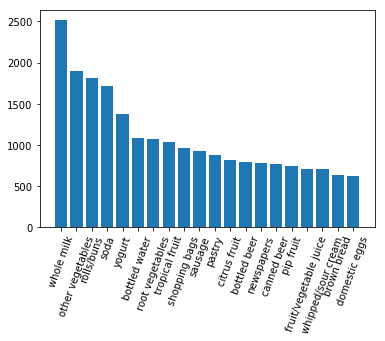

In [7]:
plt.bar(range(len(Item_count[0:20])), [val[1] for val in Item_count[0:20]], align='center')
plt.xticks(range(len(Item_count[0:20])), [val[0] for val in Item_count[0:20]])
plt.xticks(rotation=70)
plt.show()

- 상위 20개 품목의 구매 횟수
- 우유가 2500번 정도 구매 되어 가장 많이 차지
- 야채, 유제품 등 식품 관련 품목의 판매가 많음

In [8]:
def ItemCount(A,df=df):
    count=0
    n=len(df)
    for x in df:
        if set(A).issubset(x):
            count+=1
    return count

In [9]:
ItemCount(['canned beer'])

764

캔 맥주는 총 764번의 장바구니에서 나타남

# 2. 주요 개념과 용어

<b>Basket</b><br>
- 한번의 거래에서 구매된 상품 (item)의 집합
- 예를 들어 첫 번째 basket은 'citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'

In [10]:
df[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

<b>1) Support</b><br>
- $X$가 특정 item의 집합, $T$가 전체 거래의 집합(전체 basket), $t$가 $t\in T$인 각각의 basket이라고 할 때<br>
$supp(X)= \frac{|t\in T; X\in t  |}{|T|}$<br>
- item X가 전체 basket에서 나타난 비율

In [11]:
def Support(A,df=df):
    count=0
    n=len(df)
    for x in df:
        if set(A).issubset(x):
            count+=1
    return count/n
A=['canned beer']
B=['bottled beer']
C=['bottled beer','canned beer']
D=['chicken','bottled beer']
E=['chicken','canned beer']
print(Support(A))
print(Support(B))
print(Support(C))
print(Support(D))
print(Support(E))

0.07768174885612608
0.08052872394509406
0.0026436197254702592
0.002440264361972547
0.003253685815963396


- 각각의 구매에서 캔 맥주보다 병 맥주를 구매한 경우가 많음
- 치킨과 캔 맥주를 같이 구매한 경우 치킨과 병 맥주를 구매한 경우보다 많음 

<b>2) Confidence</b><br>
$conf(X->Y)=\frac{supp(XUY)  }{supp(X)}$
- baskek에 item $X$가 나타났을 때 $X$와 $Y$가 동시에 나타난 비율

In [12]:
def Confidence(A,B,df=df):
    countA=0
    countAB=0
    
    for x in df:
        if set(A).issubset(x):
            countA+=1

            if set(A+B ).issubset(x):
                countAB+=1
    return countAB/countA
A=['canned beer']
B=['bottled beer']
C=['chicken']

In [13]:
print(Confidence(C,A))
print(Confidence(C,B))
print(Confidence(A,C))
print(Confidence(B,C))

0.07582938388625593
0.05687203791469194
0.041884816753926704
0.030303030303030304


- 치킨을 구매했을 때 캔 맥주를 구매한 경우가 치킨을 구매했을 때 병 맥주를 구매한 경우 보다 많음
- 캔 맥주를 구매했을 때 치킨을 구매한 경우가 병 맥주를 구매했을 때 치킨을 구매한 경우 보다 많음

<b>3) Lift</b><br>
$Lift(X->Y)=\frac{supp(XUY)}{supp(X),supp(Y)}$<br>
- $X$와 $Y$의 독립성을 보는 것으로 둘이 독립이면 $Lift=1$
- $Lift>1$이면 상품 간에 양의 관련성있음 (보완재 관계)
- $Lift<1$이면 상품 간에 음의 관련성있음 (대체재 관계)

In [14]:
def Lift(A,B,df=df):

    Result=Confidence(A,B)/Support(B)
    return Result
A=['canned beer']
B=['bottled beer']
C=['chicken']
E=['sausage']
F=['white bread']
G=['brown bread']

In [15]:
Lift(A,B)

0.4225996879792691

In [16]:
def Lift(A,B,df=df):
    countA=0
    countB=0
    countAB=0
    n=len(df)
    for x in df:
        if set(A).issubset(x):
            countA+=1

            if set(A+B ).issubset(x):
                countAB+=1
        if set(B).issubset(x):
            countB+=1
    return (countAB/countA )/( countB/n    )
A=['canned beer']
B=['bottled beer']
C=['chicken']
E=['sausage']
F=['white bread']
G=['brown bread']

In [17]:
print(Lift(A,B))
print(Lift(A,C))
print(Lift(B,C))
print(Lift(C,E))
print(Lift(F,G))

0.4225996879792691
0.9761544378551401
0.7062329455694384
1.311575470343243
1.7128178335074884


- 캔맥주와 병맥주는 lift가 1보다 낮아 대체재의 관계
- 캔맥주와 치킨은 lift가 1에가까워 독립적 관계
- 병맥주와 치킨은 lift가 1보다 낮아 대체재의 관계<br>
=> Support와 Confidence를 봤을 때 치킨과 캔맥주의 관계가 치킨과 병맥주의 관계보다 커 보였지만 Lift로 봤을 때 치킨과 병맥주의 관계가 더 큼
- 치킨과 소세지는 lift가 1보다 높아 보완재의 관계
- 갈색 식빵과 흰 식빵은 lift가 1보다 높아 보완성이 큼


<b>4) 시사점</b>
- 세 가지 척도가 다른 결론을 줄 수 있음
- 특정 상품간의 관계를 볼 수 있지만 연관성이 큰 상품 집합을 찾으려면 경우의 수가 너무 많음

# 3. Apriori algorithm

가정: 구매 빈도가 높은 품목들의 하위 집합도 구매 빈도가 높다

1) 기준 설정 (최소 구매 빈도,support, confidence 등)<br>
2) 기준보다 높은 품목 필터링 (예를들어 [A,B,C,D..,K] 품목 선택)<br>
3) 필터링 된 품목 중 2개씩의 하위 집합 중에 기준 보다 높은 품목 필터링(예를 들어 [AB,AC...JK]중 [AB,AC,CD] 선택)<br>
4) 남은 품목중 3개씩 고려<br>
5) 기준을 만족할 때까지 계속 진행

In [79]:
min_supp=0.03
min_len=2
min_lift=1
min_conf=0.03
Items_1=[]

for x in Item_count:
    if (Support([x[0]])>min_supp) and (  x[1]  > min_len ):
        Items_1.append(x[0])

In [80]:
print( [Items_1[0:10],len(Items_1)])

[['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'bottled water', 'root vegetables', 'tropical fruit', 'shopping bags', 'sausage'], 44]


- Support가 0.01이하이면서 Basket에 나타난 횟수가 2번 이상인 상품들을 찾음
- 처음에는 단순히 구매 빈도가 기준치 보다 높은 Item을 찾는 과정

In [81]:
from itertools import combinations
Items_2_cand=list(combinations(Items_1, 2) )
print( [Items_2_cand[0:10],len(Items_2_cand)])

[[('whole milk', 'other vegetables'), ('whole milk', 'rolls/buns'), ('whole milk', 'soda'), ('whole milk', 'yogurt'), ('whole milk', 'bottled water'), ('whole milk', 'root vegetables'), ('whole milk', 'tropical fruit'), ('whole milk', 'shopping bags'), ('whole milk', 'sausage'), ('whole milk', 'pastry')], 946]


첫 번째 필터링 된 아이템 집합에서 두 개의 상품씩 묶음

In [82]:
Items_2=[]
for x in Items_2_cand:
    if  ((Support(x)>min_supp)and (Confidence([x[0]],[x[1]])>min_conf) and (Lift([x[0]],[x[1]])>min_lift ) ):
        Items_2.append(x)

In [110]:
unique=set(x for l in Items_2 for x in l)
print(Items_2)
print(len(Items_2) )
print(len(unique) )

[('whole milk', 'other vegetables'), ('whole milk', 'rolls/buns'), ('whole milk', 'yogurt'), ('whole milk', 'bottled water'), ('whole milk', 'root vegetables'), ('whole milk', 'tropical fruit'), ('whole milk', 'pastry'), ('whole milk', 'citrus fruit'), ('whole milk', 'pip fruit'), ('whole milk', 'whipped/sour cream'), ('other vegetables', 'rolls/buns'), ('other vegetables', 'yogurt'), ('other vegetables', 'root vegetables'), ('other vegetables', 'tropical fruit'), ('rolls/buns', 'soda'), ('rolls/buns', 'yogurt'), ('rolls/buns', 'sausage')]
17
13


이 중에 17개의 item 조합이 조건을 만족하며 이 조합들은 총 13개의 상품으로 구성 되어 있음

In [99]:
Items_3_cand=list(combinations(unique, 3) )
print( [Items_3_cand[0:10],len(Items_3_cand)])

[[('pastry', 'rolls/buns', 'citrus fruit'), ('pastry', 'rolls/buns', 'pip fruit'), ('pastry', 'rolls/buns', 'sausage'), ('pastry', 'rolls/buns', 'bottled water'), ('pastry', 'rolls/buns', 'whipped/sour cream'), ('pastry', 'rolls/buns', 'yogurt'), ('pastry', 'rolls/buns', 'tropical fruit'), ('pastry', 'rolls/buns', 'root vegetables'), ('pastry', 'rolls/buns', 'soda'), ('pastry', 'rolls/buns', 'whole milk')], 286]


이 13개의 상품을 3개씩 묶으면 총 286개의 조합이 나옴

In [104]:
Items_3=[]
for x in Items_3_cand:
    if  ((Support(x)>min_supp)and (Confidence([x[0],x[1]],[x[2] ])>min_conf) and (Lift([x[0],x[1]],[x[2] ])>min_lift ) ):
        Items_3.append(x)

In [105]:
len(Items_3)

0

이 조합 중에 조건을 만족하는 조합은 없으므로 여기서 stop

In [113]:
Result=[]
for x in Items_2_cand:
    if  ((Support(x)>min_supp)and (Confidence([x[0]],[x[1]])>min_conf) and (Lift([x[0]],[x[1]])>min_lift ) ):
        Result.append([x,Support(x),Confidence([x[0]],[x[1]]), Lift([x[0]],[x[1]]) ]   )

In [117]:
pd.DataFrame(Result,columns=['Item set','Support','Confidence ->','Lift  ->'  ])

,Item set,Support,Confidence ->,Lift ->
0,"(whole milk, other vegetables)",0.074835,0.292877,1.513634
1,"(whole milk, rolls/buns)",0.056634,0.221647,1.205032
2,"(whole milk, yogurt)",0.056024,0.219260,1.571735
3,"(whole milk, bottled water)",0.034367,0.134501,1.216940
4,"(whole milk, root vegetables)",0.048907,0.191405,1.756031
5,"(whole milk, tropical fruit)",0.042298,0.165539,1.577595
6,"(whole milk, pastry)",0.033249,0.130123,1.462587
7,"(whole milk, citrus fruit)",0.030503,0.119379,1.442377
8,"(whole milk, pip fruit)",0.030097,0.117788,1.557043
9,"(whole milk, whipped/sour cream)",0.032232,0.126144,1.759754


- 'whole milk'와 다른 상품 간의 추천이 많음
- 유제품과 빵 종류의 추천이 많은 것을 보아 타당해 보이는 추천도 있음
- 하지만 유제품과 채소류는 거의 모든 장바구니에 담겨 있고, 상품간의 관련성 때문에 함께 사는 것이 아닐 가능성이 높음

In [125]:
Result2=[]
for x in unique:
    Result2.append([x,Support([x])])
Result2=sorted(Result2, key = lambda x: x[1],reverse=True)

In [127]:
pd.DataFrame(Result2,columns=['Item set','Support' ])

,Item set,Support
0,whole milk,0.255516
1,other vegetables,0.193493
2,rolls/buns,0.183935
3,soda,0.174377
4,yogurt,0.139502
5,bottled water,0.110524
6,root vegetables,0.108998
7,tropical fruit,0.104931
8,sausage,0.093950
9,pastry,0.088968


- 'whole milk', 'other vegetables', 'rolls/buns' 관련 추천이 많았던 것은 각각의 제품의 support가 높았기 때문

<b>Apriori Algorithm의 장점</b>
- 구현하기 쉽고 직관적임

<b>Apriori Algorithm의 단점</b>
- 연산이 지나치게 많음<br>
=> Supoort 한번 구하는데 전체 데이터 베이스를 모두 탐색해야 되기 때문에 매우 느림
- 여러 종류의 상품을 추천하기 어려움<br>
=> 상품을 여러 종류 추천하기 위해서는 support나 기준을 낮게 설정해야 하지만 그렇게 되면 속도가 훨씬 느려짐<br>
=> 속도가 느리기 때문에 파라미터를 여러 번 바꿔보기가 어려움
- 자주 구매하는 상품을 탐색하기 때문에 일상적인 상품 위주로 추천됨<br>
=> 예를들어 우유나 야채는 생활 필수품에 가깝기 때문에 추천이 의미 없을 수 있음
- 동시에 구매한다고 해서 관련성이 있는 것은 아닐 수 있지만 이를 반영할 수 없음

데이터 및 코드<br>
- https://github.com/datascienceabe/study_open/tree/master/recommender_system/code

출처:<br>
- http://www.sci.csueastbay.edu/~esuess/classes/Statistics_6620/Presentations/ml13/groceries.csv
- http://www.shawonruet.com/2018/06/apriori-algorithm-implementation-in.html
- https://en.wikipedia.org/wiki/Association_rule_learning